# Applying the model on the data

In [1]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
import utils


import os
import warnings
warnings.filterwarnings("ignore")
DATA_FOLDER = '../data/'
sales_util = utils.SalesUtils('../submissions')

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
dfmain  = pd.read_csv(os.path.join(DATA_FOLDER, 'df_main_with_test.csv'))
df_test  = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [3]:
dates = dfmain['date_block_num']

#define the index cols
index_cols = ['shop_id', 'item_id', 'date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [7]:
# List of all lagged features
index_cols = ['shop_id', 'item_id', 'date_block_num']
shift_range = [1,2,3,4,5,6,7,12]
mean_enc_cols = [col for col in dfmain.columns if 'mean' in str(col)]
fit_cols = [col for col in dfmain.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols = fit_cols + mean_enc_cols + ['city_id','item_category_id','num_days'] #'num_sun'
# We will drop these at fitting stage
to_drop_cols = list(set(list(dfmain.columns)) - (set(fit_cols)|set(index_cols))) 
# + ['date_block_num', 'city_id_mean_target','item_cat_mean_target'] 

In [8]:
fit_cols

['revenue_lag_1',
 'revenue_item_lag_1',
 'revenue_shop_lag_1',
 'target_lag_1',
 'target_item_lag_1',
 'target_shop_lag_1',
 'revenue_lag_2',
 'revenue_item_lag_2',
 'revenue_shop_lag_2',
 'target_lag_2',
 'target_item_lag_2',
 'target_shop_lag_2',
 'revenue_lag_3',
 'revenue_item_lag_3',
 'revenue_shop_lag_3',
 'target_lag_3',
 'target_item_lag_3',
 'target_shop_lag_3',
 'revenue_lag_11',
 'revenue_item_lag_11',
 'revenue_shop_lag_11',
 'target_lag_11',
 'target_item_lag_11',
 'target_shop_lag_11',
 'revenue_lag_12',
 'revenue_item_lag_12',
 'revenue_shop_lag_12',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12',
 'shop_id_exp_y_mean',
 'month_mean_target',
 'item_cat_mean_target',
 'item_cat_db_mean_target',
 'shop_id_mean_target',
 'shop_id_db_mean_target',
 'city_id_mean_target',
 'city_db_mean_target',
 'shop_city_mean',
 'city_id',
 'item_category_id',
 'num_days']

In [9]:
to_drop_cols

['revenue',
 'month',
 'target_shop',
 'revenue_item',
 'target_item',
 'parent_cat_id',
 'revenue_shop',
 'num_sun',
 'target']

In [10]:
dfmain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818986 entries, 0 to 5818985
Data columns (total 54 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   shop_id                  int64  
 1   item_id                  int64  
 2   date_block_num           int64  
 3   month                    int64  
 4   target                   float64
 5   revenue                  float64
 6   target_shop              float64
 7   revenue_shop             float64
 8   target_item              float64
 9   revenue_item             float64
 10  item_category_id         int64  
 11  parent_cat_id            int64  
 12  city_id                  int64  
 13  num_sun                  int64  
 14  num_days                 int64  
 15  revenue_lag_1            float64
 16  revenue_item_lag_1       float64
 17  revenue_shop_lag_1       float64
 18  target_lag_1             float64
 19  target_item_lag_1        float64
 20  target_shop_lag_1        float64
 21  revenue_

In [14]:
dfmain['date_block_num'] = dfmain['date_block_num'].astype('int8')
dfmain['shop_id'] = dfmain['shop_id'].astype('category')
dfmain['item_id'] = dfmain['item_id'].astype('category')
dfmain['num_sun'] = dfmain['num_sun'].astype('category')
dfmain['month'] = dfmain['month'].astype('category')
dfmain['item_category_id'] = dfmain['item_category_id'].astype('category')
dfmain['parent_cat_id'] = dfmain['parent_cat_id'].astype('category')
dfmain['city_id'] = dfmain['city_id'].astype('category')
dfmain['num_days'] = dfmain['num_days'].astype('category')

target_cols = [col for col in dfmain.columns if 'target' in str(col)]
for col in target_cols:
    dfmain[col] = dfmain[col].astype('float16')

# getting the mean attributes
mean_enc_cols = [col for col in dfmain.columns if 'mean' in str(col)]
for col in mean_enc_cols:
    dfmain[col] = dfmain[col].astype('float16')
    
# getting the mean attributes
revenue_cols = [col for col in dfmain.columns if 'revenue' in str(col)]
for col in revenue_cols:
    dfmain[col] = dfmain[col].astype('float32')

In [15]:
dfmain.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818986 entries, 0 to 5818985
Data columns (total 54 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   shop_id                  category
 1   item_id                  category
 2   date_block_num           int8    
 3   month                    category
 4   target                   float16 
 5   revenue                  float32 
 6   target_shop              float16 
 7   revenue_shop             float32 
 8   target_item              float16 
 9   revenue_item             float32 
 10  item_category_id         category
 11  parent_cat_id            category
 12  city_id                  category
 13  num_sun                  category
 14  num_days                 category
 15  revenue_lag_1            float32 
 16  revenue_item_lag_1       float32 
 17  revenue_shop_lag_1       float32 
 18  target_lag_1             float16 
 19  target_item_lag_1        float16 
 20  target_shop_lag_1       

In [16]:
#split
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = dfmain.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_test =  dfmain.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_valid = dfmain.loc[dates == last_block-1].drop(to_drop_cols, axis=1)

y_train = dfmain.loc[dates <  last_block-1, 'target'].values
y_test =  dfmain.loc[dates == last_block, 'target'].values
y_valid =  dfmain.loc[dates == last_block-1, 'target'].values

y_train = y_train.clip(0,20)
y_valid = y_valid.clip(0,20)

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5366614 entries, 0 to 5366613
Data columns (total 45 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   shop_id                  category
 1   item_id                  category
 2   date_block_num           int8    
 3   item_category_id         category
 4   city_id                  category
 5   num_days                 category
 6   revenue_lag_1            float32 
 7   revenue_item_lag_1       float32 
 8   revenue_shop_lag_1       float32 
 9   target_lag_1             float16 
 10  target_item_lag_1        float16 
 11  target_shop_lag_1        float16 
 12  revenue_lag_2            float32 
 13  revenue_item_lag_2       float32 
 14  revenue_shop_lag_2       float32 
 15  target_lag_2             float16 
 16  target_item_lag_2        float16 
 17  target_shop_lag_2        float16 
 18  revenue_lag_3            float32 
 19  revenue_item_lag_3       float32 
 20  revenue_shop_lag_3      

In [30]:
cat_features = list(X_train.select_dtypes(include=['category']).columns)

In [31]:
#training the LGB
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train,label=y_train), 
                  150, categorical_feature=cat_features, 
                  valid_sets=lgb.Dataset(X_valid,label=y_valid), verbose_eval=True)
pred_lgb = model.predict(X_test)

[1]	valid_0's rmse: 1.12617
[2]	valid_0's rmse: 1.11648
[3]	valid_0's rmse: 1.10769
[4]	valid_0's rmse: 1.09774
[5]	valid_0's rmse: 1.08905
[6]	valid_0's rmse: 1.08156
[7]	valid_0's rmse: 1.07461
[8]	valid_0's rmse: 1.06793
[9]	valid_0's rmse: 1.06169
[10]	valid_0's rmse: 1.05586
[11]	valid_0's rmse: 1.04916
[12]	valid_0's rmse: 1.04401
[13]	valid_0's rmse: 1.0385
[14]	valid_0's rmse: 1.03412
[15]	valid_0's rmse: 1.02838
[16]	valid_0's rmse: 1.02451
[17]	valid_0's rmse: 1.02086
[18]	valid_0's rmse: 1.01761
[19]	valid_0's rmse: 1.01437
[20]	valid_0's rmse: 1.01118
[21]	valid_0's rmse: 1.00876
[22]	valid_0's rmse: 1.00433
[23]	valid_0's rmse: 1.00223
[24]	valid_0's rmse: 0.999733
[25]	valid_0's rmse: 0.997948
[26]	valid_0's rmse: 0.994169
[27]	valid_0's rmse: 0.992609
[28]	valid_0's rmse: 0.991098
[29]	valid_0's rmse: 0.989431
[30]	valid_0's rmse: 0.988323
[31]	valid_0's rmse: 0.985373
[32]	valid_0's rmse: 0.982652
[33]	valid_0's rmse: 0.981805
[34]	valid_0's rmse: 0.980782
[35]	valid_0'

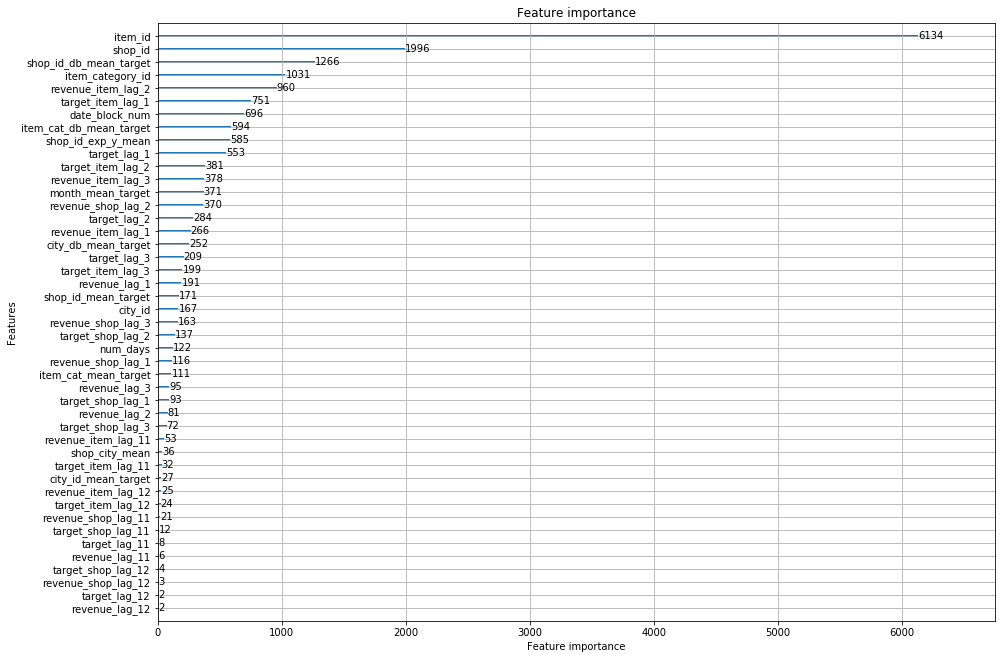

In [32]:
lgb.plot_importance(model, figsize=(15,11))

In [71]:
df_test['item_cnt_month'] = pred_lgb.clip(0,20)
df_submission= df_test[['ID','item_cnt_month']]
sales_util.save_submission('25jul2020_edx_lgb_6',df_submission)

Submission file saved as ../submissions\sub_24jul2020_edx_lgb_6_2020-07-24.csv
